# 로지스틱 회귀 (이항분류)

## #01. 패키지 준비하기

In [1]:
import sys
sys.path.append('../../')
import helper

import numpy as np
from pandas import read_excel, DataFrame, get_dummies, merge
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

## #02. 데이터셋 준비하기

In [3]:
origin = read_excel("https://data.hossam.kr/F03/biostat.xlsx", index_col='id')
origin.head()

,age,sex,weight,OP_date,Recur,Recur_1y,Recur_date,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,,,,
1,82,1,73.994588,2014-07-10,1,0,2015-08-12,144.286869,4490.5,0.1,3.0,5.1,3,1,1,36.795194,0,1
2,50,0,64.819694,2013-05-08,0,0,2018-07-07,108.590964,36.7,0.1,1.1,1.5,3,1,0,32.765043,0,1
3,28,1,63.204675,2016-05-06,0,0,2020-01-13,5.629379,36.7,0.1,10.7,12.4,3,1,0,31.133072,0,1
4,35,1,52.499192,2015-11-24,1,0,2017-08-07,143.931300,64.9,1.3,1.3,0.4,3,1,1,36.134051,0,1
5,49,1,72.766264,2015-02-12,1,0,2016-06-02,172.653143,38.2,10.7,3.7,0.4,3,1,0,33.921657,0,1


## #03. 데이터 전처리

### 결측치 확인

In [5]:
origin.isna().sum()

age                   0
sex                   0
weight                0
OP_date               0
Recur                 0
Recur_1y              0
Recur_date            0
SBP                   0
CA19.9                0
CRP                   0
CEA                   0
post.CEA              0
stage                 0
smoking               0
obesity               0
post.CA19.9           0
post.CA19.9.binary    0
post.CA19.9.3grp      0
dtype: int64

> 결측치 없음

### 문제에서 제외하도록 정의한 필드는 제거

In [6]:
df = origin.drop(['Recur_1y', 'OP_date', 'Recur_date'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 156 non-null    int64  
 1   sex                 156 non-null    int64  
 2   weight              156 non-null    float64
 3   Recur               156 non-null    int64  
 4   SBP                 156 non-null    float64
 5   CA19.9              156 non-null    float64
 6   CRP                 156 non-null    float64
 7   CEA                 156 non-null    float64
 8   post.CEA            156 non-null    float64
 9   stage               156 non-null    int64  
 10  smoking             156 non-null    int64  
 11  obesity             156 non-null    int64  
 12  post.CA19.9         156 non-null    float64
 13  post.CA19.9.binary  156 non-null    int64  
 14  post.CA19.9.3grp    156 non-null    int64  
dtypes: float64(7), int64(8)
memory usage: 19.5 KB


## #04. 탐색적 데이터 분석

### 명목형에 대한 데이터 타입 설정

In [7]:
df['sex'] = df['sex'].astype('category')
df['Recur'] = df['Recur'].astype('category')
df['stage'] = df['stage'].astype('category')
df['smoking'] = df['smoking'].astype('category')
df['obesity'] = df['obesity'].astype('category')
df['post.CA19.9.binary'] = df['post.CA19.9.binary'].astype('category')
df['post.CA19.9.3grp'] = df['post.CA19.9.3grp'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   age                 156 non-null    int64   
 1   sex                 156 non-null    category
 2   weight              156 non-null    float64 
 3   Recur               156 non-null    category
 4   SBP                 156 non-null    float64 
 5   CA19.9              156 non-null    float64 
 6   CRP                 156 non-null    float64 
 7   CEA                 156 non-null    float64 
 8   post.CEA            156 non-null    float64 
 9   stage               156 non-null    category
 10  smoking             156 non-null    category
 11  obesity             156 non-null    category
 12  post.CA19.9         156 non-null    float64 
 13  post.CA19.9.binary  156 non-null    category
 14  post.CA19.9.3grp    156 non-null    category
dtypes: category(7), float64(7), int64(1)
memory u

### 기술통계량 확인

In [8]:
df.describe()

,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,56.858974,68.125624,115.898871,1158.631410,3.062821,3.930128,5.363462,48.193259
std,12.790343,14.467480,37.701583,6709.440806,3.550361,4.135752,12.846207,22.921452
min,25.000000,40.000000,5.629379,1.000000,0.100000,0.300000,0.100000,30.760115
25%,50.000000,58.257205,89.074804,10.400000,0.100000,1.500000,0.600000,34.908674
50%,58.000000,69.084391,114.647853,23.150000,1.300000,2.400000,1.650000,41.285774
75%,65.000000,80.053547,144.331917,61.725000,4.850000,4.525000,4.800000,51.216016
max,82.000000,95.000000,206.847716,48599.800000,12.300000,20.400000,118.500000,174.433426


### 상자그림 확인

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

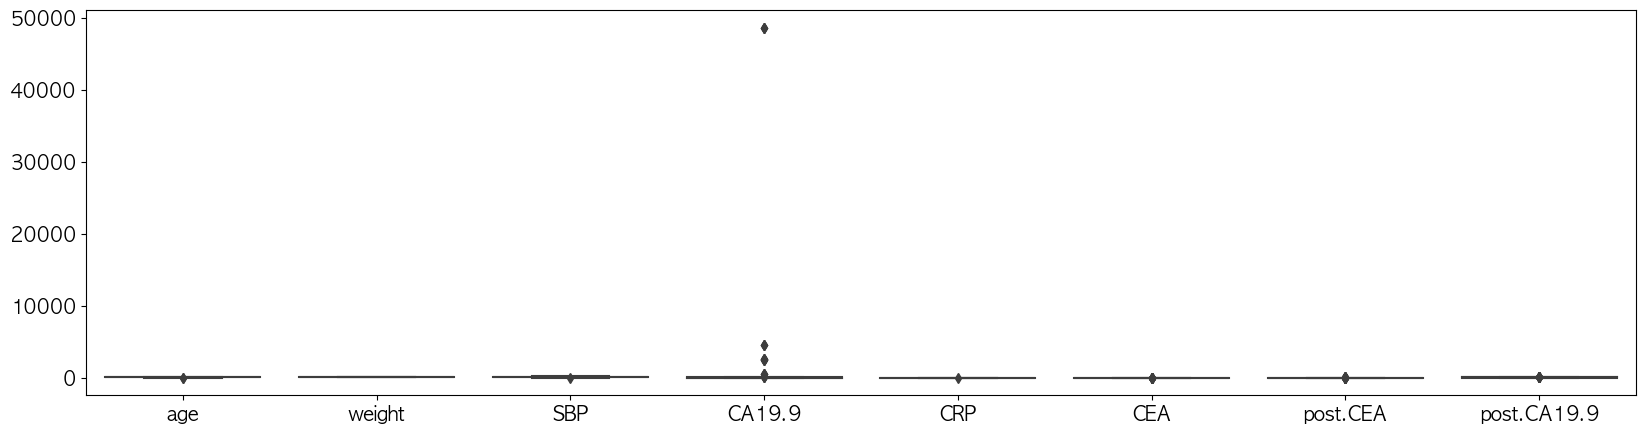

In [9]:
plt.figure(figsize=(20, 5))
sb.boxplot(data=df)
plt.show()
plt.close()

> "CA19.9"에서 약 50000정도의 값이 발견되었음. 이 값을 이상치인지 확인이 필요함

### 이상치 확인

In [10]:
df.query("`CA19.9` > 40000")

,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,
11,64,1,87.019677,1,93.901218,48599.6,9.4,1.4,3.9,2,1,1,34.956666,0,1
63,60,1,80.024716,1,192.226734,48599.8,9.7,4.7,9.5,2,0,1,41.421145,1,2
115,61,1,74.031541,1,176.594650,48599.3,10.4,6.6,6.6,2,0,1,36.516956,0,1


> 수치가 4만이 넘는 경우가 모두 췌장암 2기로 확인됨(stage==2)

In [11]:
df.query("stage == 2")

,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,
9,69,0,53.920287,1,108.237287,19.9,0.1,4.6,15.1,2,1,0,62.095475,1,2
10,39,1,64.035273,0,88.061020,84.2,9.6,4.3,6.1,2,1,0,50.118498,1,2
11,64,1,87.019677,1,93.901218,48599.6,9.4,1.4,3.9,2,1,1,34.956666,0,1
12,69,1,70.208801,1,163.587691,49.5,0.1,7.2,8.2,2,1,1,34.626853,0,1
23,64,1,82.150157,0,169.410154,67.3,3.5,1.8,0.9,2,1,0,34.890297,0,1
26,59,0,60.346471,0,121.918068,12.7,1.7,1.2,0.2,2,1,0,44.344380,1,2
27,41,0,53.729653,0,95.660858,7.6,0.1,8.3,19.4,2,1,1,34.043468,0,1
29,48,1,70.060164,0,108.765715,15.0,3.8,6.8,3.6,2,0,0,44.855612,1,2
30,34,1,71.468074,0,51.737041,49.6,3.9,4.2,1.5,2,0,0,43.407932,1,2


> 다른 췌장암 2기와 비교했을 경우 큰 차이가 나므로 `CA19.9` 수치가 4만을 넘는 경우를 이상치로 판단하고 제거하기로 함

### 이상치 정제

> 성능 분석 다 한 후에 이 이상치들을 정제하지 않은 데이터를 갖고 모델을 만들어 성능을 확인해 본 결과,
>
> 실패율이 높아졌었다. 
> 
> 데이터의 수가 적을 뿐더러, 이 이상치들을 포함하면 학습 성능에도 좋지 않은 영향을 줄 것으로 판단하고 (데이터의 수 자체가 작은데 이 이상치마저 포함하면 이상치의 비율이 전체 데이터에서 차지하는 비율이 크기 때문에) 이 이상치들을 제거하는 것이 옳아 보인다?

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

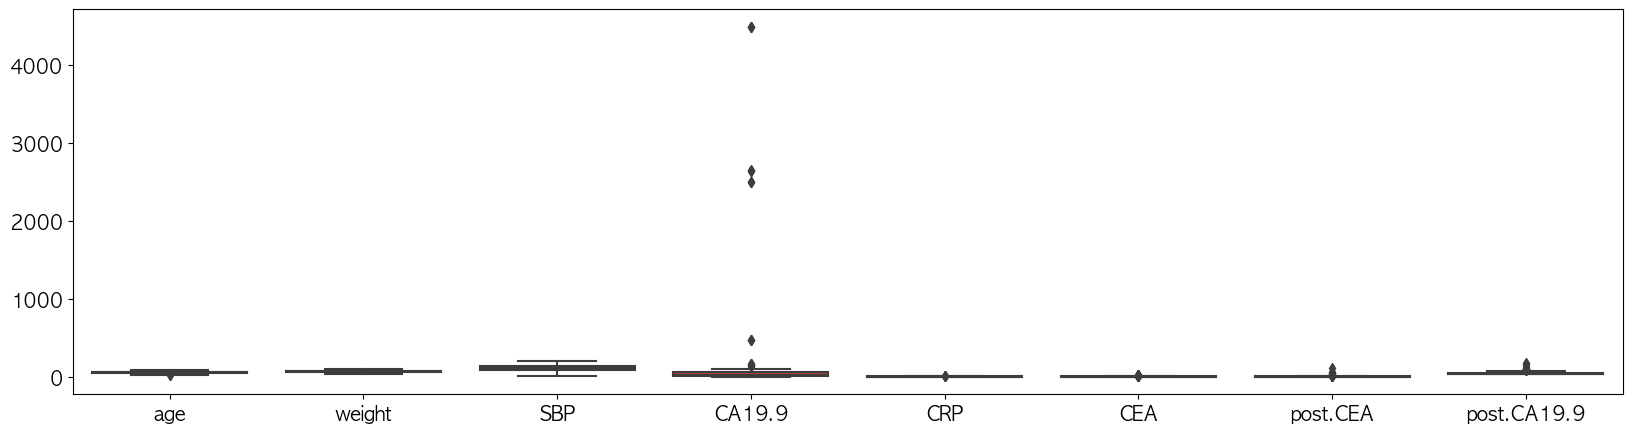

In [12]:
df2 = df.drop(df.query("`CA19.9` > 40000").index)

plt.figure(figsize=(20, 5))
sb.boxplot(data=df2)
plt.show()
plt.close()

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [13]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [14]:
x = df2.drop(['Recur'], axis=1)
y = df2['Recur']

x.shape, y.shape

((153, 14), (153,))

### 데이터 표준화

#### 명목형 변수는 더미변수로 변환해야 하므로 데이터를 종류별로 구분

##### 연속형 변수만 추출

In [15]:
x1 = x.drop(['sex', 'stage', 'smoking', 'obesity', 'post.CA19.9.binary', 'post.CA19.9.3grp'], axis=1)
x1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 156
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          153 non-null    int64  
 1   weight       153 non-null    float64
 2   SBP          153 non-null    float64
 3   CA19.9       153 non-null    float64
 4   CRP          153 non-null    float64
 5   CEA          153 non-null    float64
 6   post.CEA     153 non-null    float64
 7   post.CA19.9  153 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 10.8 KB


#### 명목형 변수만 추출

In [16]:
x2 = x.filter(['sex', 'stage', 'smoking', 'obesity', 'post.CA19.9.binary', 'post.CA19.9.3grp'])
x2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 156
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   sex                 153 non-null    category
 1   stage               153 non-null    category
 2   smoking             153 non-null    category
 3   obesity             153 non-null    category
 4   post.CA19.9.binary  153 non-null    category
 5   post.CA19.9.3grp    153 non-null    category
dtypes: category(6)
memory usage: 2.8 KB


#### 연속형 변수에 대한 표준화

In [17]:
scaler = StandardScaler()
x_scale = scaler.fit_transform(x1)
x_scale_df = DataFrame(x_scale, index=x1.index, columns=x1.columns)
# id인 인덱스를 꼭 넣어줘서 id를 유지해줘야된다 - 나중에 id로 데이터를 병합할 것이기 때문에
x_scale_df.head()

,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9
id,,,,,,,,
1,1.963300,0.423063,0.786098,5.459243,-0.822126,-0.222609,-0.018407,-0.504152
2,-0.526293,-0.212338,-0.176862,-0.245568,-0.822126,-0.680266,-0.296946,-0.679230
3,-2.237888,-0.324186,-2.954433,-0.245568,-0.822126,1.632102,0.546406,-0.750126
4,-1.693289,-1.065587,0.776506,-0.209447,-0.473529,-0.632091,-0.382054,-0.532873
5,-0.604092,0.337996,1.551328,-0.243646,2.257144,-0.053999,-0.382054,-0.628984


#### 명목형 변수를 더미변수로 변환

##### 데이터의 종류가 몇가지인지 확인

데이터 엑셀파일에서 `stage`, `post.CA19.9.3grp` 필드만 값이 3종류로 확인되므로 이 변수들만 더미변수로 변환

In [18]:
x2_dm = get_dummies(x2, columns=['stage', 'post.CA19.9.3grp'], drop_first=True, dtype='int')
x2_dm.head()

,sex,smoking,obesity,post.CA19.9.binary,stage_2,stage_3,post.CA19.9.3grp_2,post.CA19.9.3grp_3
id,,,,,,,,
1,1,1,1,0,0,1,0,0
2,0,1,0,0,0,1,0,0
3,1,1,0,0,0,1,0,0
4,1,1,1,0,0,1,0,0
5,1,1,0,0,0,1,0,0


### 연속형과 더미변수로 변환된 명목형을 결합

In [19]:
xdf = merge(x_scale_df, x2_dm, left_index=True, right_index=True)
print(xdf.shape)
xdf.head()

(153, 16)


,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9,sex,smoking,obesity,post.CA19.9.binary,stage_2,stage_3,post.CA19.9.3grp_2,post.CA19.9.3grp_3
id,,,,,,,,,,,,,,,,
1,1.963300,0.423063,0.786098,5.459243,-0.822126,-0.222609,-0.018407,-0.504152,1,1,1,0,0,1,0,0
2,-0.526293,-0.212338,-0.176862,-0.245568,-0.822126,-0.680266,-0.296946,-0.679230,0,1,0,0,0,1,0,0
3,-2.237888,-0.324186,-2.954433,-0.245568,-0.822126,1.632102,0.546406,-0.750126,1,1,0,0,0,1,0,0
4,-1.693289,-1.065587,0.776506,-0.209447,-0.473529,-0.632091,-0.382054,-0.532873,1,1,1,0,0,1,0,0
5,-0.604092,0.337996,1.551328,-0.243646,2.257144,-0.053999,-0.382054,-0.628984,1,1,0,0,0,1,0,0


### 훈련 데이터와 검증 데이터로 분할

In [20]:
x_train, x_test, y_train, y_test = train_test_split(xdf, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((107, 16), (46, 16), (107,), (46,))

## #06. 모델 개발

### 모델 정의

In [21]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(16, )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [22]:
result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
4/4 [==============================] - 0s 43ms/step - loss: 0.6632 - acc: 0.6075 - val_loss: 0.7274 - val_acc: 0.4348 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 7ms/step - loss: 0.6332 - acc: 0.6636 - val_loss: 0.7210 - val_acc: 0.4783 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 7ms/step - loss: 0.6152 - acc: 0.6916 - val_loss: 0.7155 - val_acc: 0.4783 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 8ms/step - loss: 0.6024 - acc: 0.7009 - val_loss: 0.7096 - val_acc: 0.4783 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 7ms/step - loss: 0.5911 - acc: 0.7196 - val_loss: 0.7060 - val_acc: 0.4783 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 8ms/step - loss: 0.5820 - acc: 0.7383 - val_loss: 0.7021 - val_acc: 0.4783 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 7ms/step - loss: 0.5711 - acc: 0.7290 - val_loss: 0.6981 - val_acc: 0.4783 - lr: 0.0010
Epoch

## #07. 학습 결과 평가

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

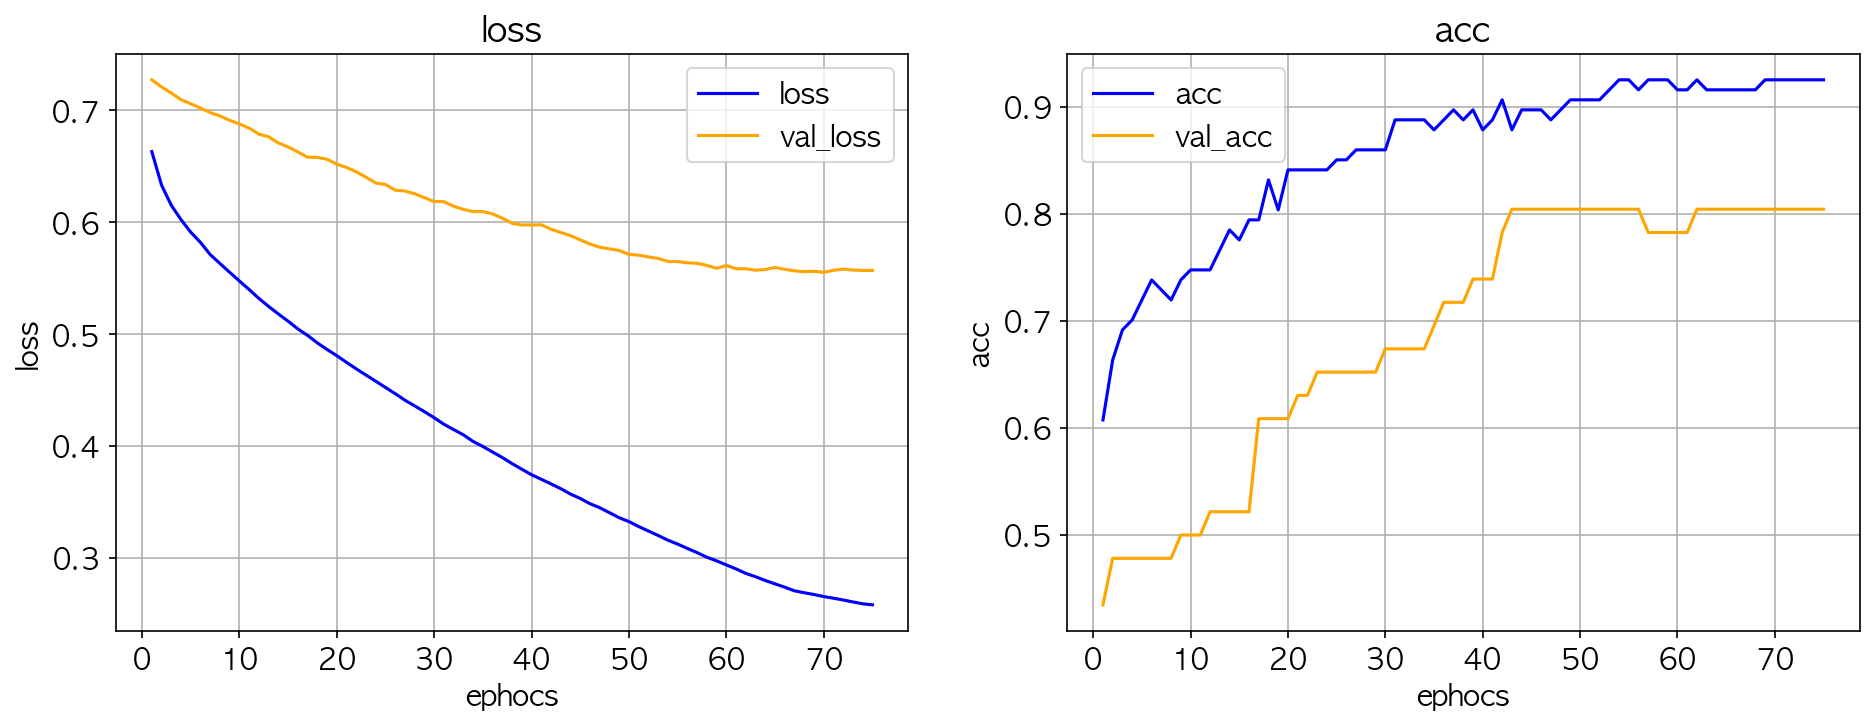

4/4 [==============================] - 0s 2ms/step - loss: 0.2571 - acc: 0.9252
최종 훈련 손실률: 0.257149, 최종 훈련 정확도: 0.925234
2/2 [==============================] - 0s 2ms/step - loss: 0.5570 - acc: 0.8043
최종 검증 손실률: 0.556959, 최종 검증 정확도: 0.804348


In [23]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

> 손실률의 격차가 이렇게 커지면 과적합이 발생했다고 본다
>
> 이럴 경우 1차적으로는 데이터의 수를 늘려야 된다 (조사된 표본의 수가 적다는 의미)
>
> 정확도가 높은 편인 것은 의심을 해봐야 한다.

#### 혼동행렬

In [24]:
logit_result = helper.tf_logit_result(model, result, x_train, y_train)
logit_result.cmdf

4/4 [==============================] - 0s 1ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


,Negative,Positive
True,46,7
False,1,53


## #08. 학습 결과 적용

### 예측 결과 산정

In [25]:
train_pred = model.predict(x_train)
train_pred

4/4 [==============================] - 0s 1ms/step


array([[0.9746154 ],
       [0.24188532],
       [0.18650363],
       [0.05893216],
       [0.24973826],
       [0.15144533],
       [0.9711189 ],
       [0.2713023 ],
       [0.88442814],
       [0.39210418],
       [0.20900322],
       [0.663504  ],
       [0.26976264],
       [0.89534515],
       [0.21109083],
       [0.26164892],
       [0.96072817],
       [0.8328145 ],
       [0.93625504],
       [0.39294493],
       [0.999049  ],
       [0.6190634 ],
       [0.9983694 ],
       [0.9755797 ],
       [0.20373498],
       [0.23479295],
       [0.22922266],
       [0.7928952 ],
       [0.9747924 ],
       [0.4094409 ],
       [0.20611656],
       [0.48700458],
       [0.2727867 ],
       [0.35325342],
       [0.48327324],
       [0.9949821 ],
       [0.7842797 ],
       [0.9911572 ],
       [0.9043837 ],
       [0.88489443],
       [0.3782078 ],
       [0.92981005],
       [0.9635327 ],
       [0.9662067 ],
       [0.3054364 ],
       [0.39360195],
       [0.43212992],
       [0.958

In [26]:
test_pred = model.predict(x_test)
test_pred

2/2 [==============================] - 0s 3ms/step


array([[0.31864798],
       [0.7574079 ],
       [0.17521316],
       [0.31963757],
       [0.80020183],
       [0.11105976],
       [0.23324686],
       [0.8424736 ],
       [0.81010157],
       [0.28268617],
       [0.94213885],
       [0.9258419 ],
       [0.57864547],
       [0.17804085],
       [0.27576795],
       [0.31890017],
       [0.5575734 ],
       [0.5323844 ],
       [0.27637845],
       [0.39361626],
       [0.12687643],
       [0.26705965],
       [0.57095695],
       [0.49530414],
       [0.75096893],
       [0.28099433],
       [0.2588556 ],
       [0.90813726],
       [0.68424016],
       [0.9964719 ],
       [0.8763863 ],
       [0.64630306],
       [0.9885515 ],
       [0.99995315],
       [0.67652124],
       [0.5124231 ],
       [0.144377  ],
       [0.32840598],
       [0.7985426 ],
       [0.97203773],
       [0.28480145],
       [0.13550891],
       [0.13207057],
       [0.29188132],
       [0.90157074],
       [0.5988515 ]], dtype=float32)

### 결과 데이터 셋 구성
- 위의 값들은 확률이기 때문에 이 것을 0과 1의 값으로 변환해야 된다

In [33]:
train_pred_bin = (train_pred.flatten() > 0.5).astype(int)
train_pred_bin
# bin = binary의 약자

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1])

In [36]:
train_result_df = DataFrame({'y_train': y_train, 'train_pred': train_pred_bin})
train_result_df

,y_train,train_pred
id,,
126,1,1
155,0,0
133,0,0
134,0,0
103,0,0
...,...,...
74,1,1
90,0,0
61,1,0


In [37]:
train_result_df['result'] = train_result_df['y_train'] == train_result_df['train_pred']
train_result_df

,y_train,train_pred,result
id,,,
126,1,1,True
155,0,0,True
133,0,0,True
134,0,0,True
103,0,0,True
...,...,...,...
74,1,1,True
90,0,0,True
61,1,0,False


In [38]:
train_value_counts = train_result_df['result'].value_counts()
train_value_counts

result
True     99
False     8
Name: count, dtype: int64

In [40]:
test_pred_bin = (test_pred.flatten() > 0.5).astype(int)
test_result_df = DataFrame({'y_test': y_test, 'test_pred': test_pred_bin})
test_result_df['result'] = test_result_df['y_test'] == test_result_df['test_pred']
test_value_counts = test_result_df['result'].value_counts()
test_value_counts

result
True     37
False     9
Name: count, dtype: int64

In [44]:
result_df = DataFrame({
    'Train': [train_value_counts[True], train_value_counts[False]],
    'Test': [test_value_counts[True], test_value_counts[False]]},
    index=['Sucess', 'Fail'])

result_df

,Train,Test
Sucess,99,37
Fail,8,9


### 실제 결과값과 머신러닝에 의한 예측값 비교

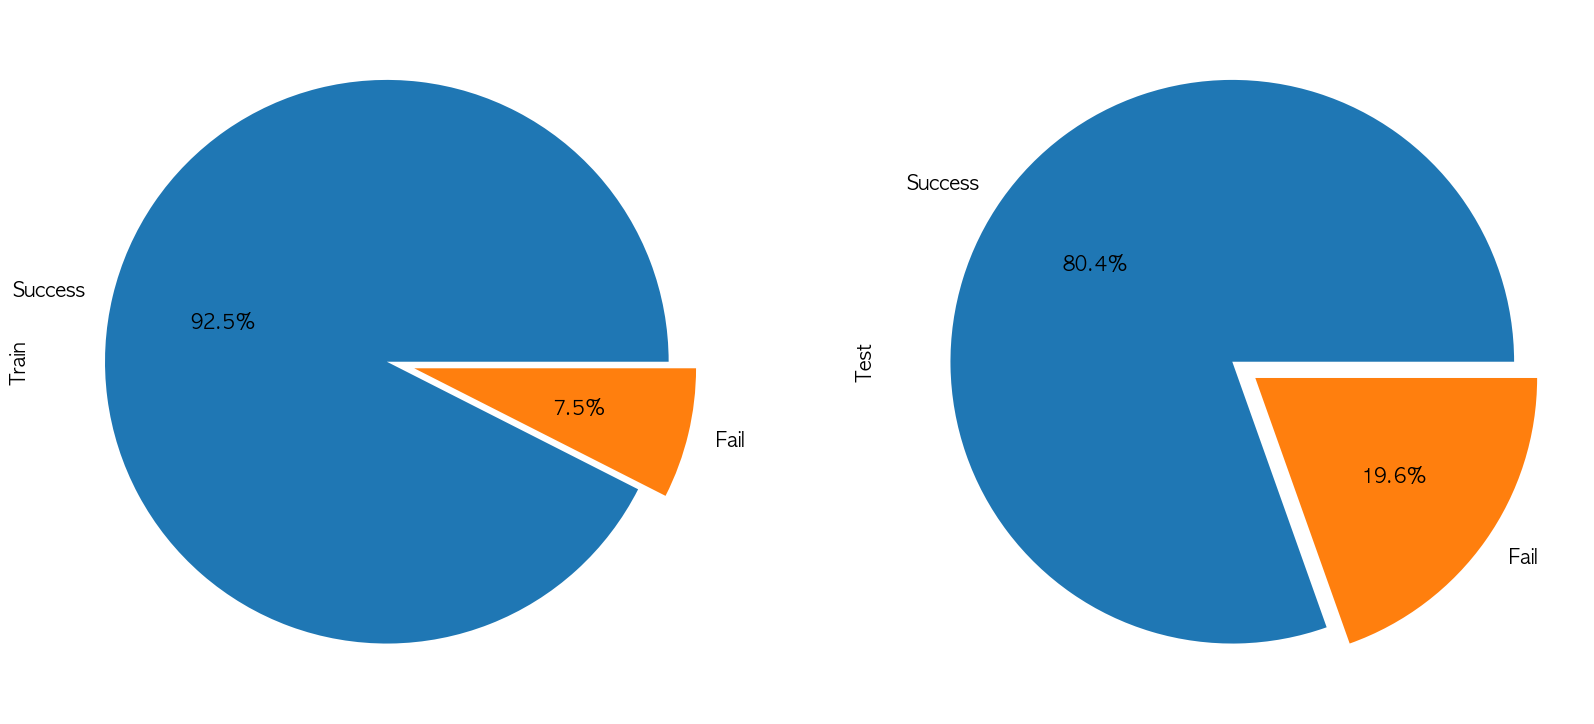

In [42]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

result_df['Train'].plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax1)
result_df['Test'].plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax2)

plt.show()
plt.close()

> 의학 분류 분석이 아니고 일반적인 분류 분석이라면 이 정도의 성능은 만족할 만 하다
>
> 하지만 실제 의학계에서는 더 높은 성능을 요구할 것이다.